# Getting data from the Gene Expression Omnibus

We have already searched online using [ArrayExpress](https://www.ebi.ac.uk/arrayexpress/) web interface and decided that we want to download certain experiment. To download the data, all we need is the accession number (eg `GSE12345`) and the `GEO2pandas` module. Since `GEO2pandas` is (still) not available throught `pip`, we need to do as follows:

In [1]:
import sys
sys.path.append("../") # this points to where the GEO2pandas code is in my computer
import GEO2pandas

In addition, we import some standard modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA

### Download the data

In [3]:
gse = GEO2pandas.get_gse("GSE64567")

11-Jul-2023 13:51:29 DEBUG utils - Directory ./ already exists. Skipping.
11-Jul-2023 13:51:29 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE64nnn/GSE64567/soft/GSE64567_family.soft.gz to ./GSE64567_family.soft.gz
100%|██████████| 28.2M/28.2M [00:02<00:00, 13.9MB/s]
11-Jul-2023 13:51:33 DEBUG downloader - Size validation passed
11-Jul-2023 13:51:33 DEBUG downloader - Moving /var/folders/jy/mpqy4_yn7k50zgjy8wz8th6r0000gp/T/tmpt9ddgkmb to /Users/szapperi/CloudStation/geopandas-tutorial/notebooks/GSE64567_family.soft.gz
11-Jul-2023 13:51:33 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE64nnn/GSE64567/soft/GSE64567_family.soft.gz
11-Jul-2023 13:51:33 INFO GEOparse - Parsing ./GSE64567_family.soft.gz: 
11-Jul-2023 13:51:33 DEBUG GEOparse - DATABASE: GeoMiame
11-Jul-2023 13:51:33 DEBUG GEOparse - SERIES: GSE64567
11-Jul-2023 13:51:33 DEBUG GEOparse - PLATFORM: GPL10558
11-Jul-2023 13:51:35 DEBUG GEOparse - SAMPLE: GSM1574423
11-Jul

### Get the metadata
To get the metadata, we use the `get_meta_from_gse` function. It will return a `pandas.DataFrame` object, which is like an 2-D array, but with **named** rows and columns

In [5]:
meta = GEO2pandas.get_meta_from_gse(gse)

Using the `.head()` method, we see the first rows of `meta`. Each row represents a sample, and each column a variable. This dataset is nice because it has lots of metadata, but that is not always the case. 

In [6]:
meta.head()

,age,bmi_(kg/m2),diastolic_blood_pressure_(mm_hg),fasting_plasma_glucose_(mg/dl),fasting_plasma_insulin_(μu/ml),gender,high_density_lipoprotein_cholesterol_(mg/dl),sample_id,systolic_blood_pressure_(mm_hg),tissue,total_cholesterol_(mg/dl),triacylglycerol_(mg/dl),waist_circumference_(cm)
GSM1574423,48,26.7,89,107,3.9,M,50,SA00093,137,"abdominal subcutaneous adipose tissue, fasted",198,72,87.8
GSM1574424,47,28.1,67,110,8.3,M,42.2,SA00204,124,"abdominal subcutaneous adipose tissue, fasted",214,95,100.6
GSM1574425,68,27.3,68,105,6.6,F,62.5,SA00228,138,"abdominal subcutaneous adipose tissue, fasted",165,96,87.3
GSM1574426,44,30.3,85,112,6.7,M,40.3,SA00236,137,"abdominal subcutaneous adipose tissue, fasted",250,232,93.7
GSM1574427,47,29,40,95,5.9,F,42.2,SA00254,105,"abdominal subcutaneous adipose tissue, fasted",187,106,98.6


### Inspect the metadata
It is important to make sure that the metadata actually contains the information we are interested in. In our case, our keyword was **obesity**, so we can use the `bmi_(kg/m2)` column. Before proceeding, we take a look at the data, printing the first value:

In [7]:
meta["bmi_(kg/m2)"][0]

' 26.7'

It seems to be a string instead of a float! We can further check with the `type()` function

In [8]:
type(meta["bmi_(kg/m2)"][0])

str

So we need to cast the column to float types. We create a new column called simply `bmi`

In [9]:
meta["bmi"] = meta["bmi_(kg/m2)"].astype(float)

Now we can plot a histogram of BMI values

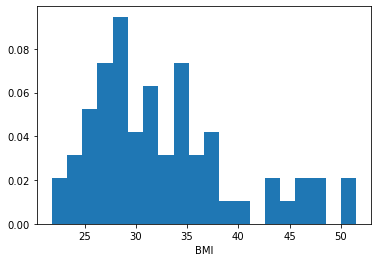

In [11]:
plt.hist(meta["bmi"], bins=20, density=True);
plt.xlabel("BMI");

Since we want to compare expression of genes between groups, we create a **cathegorical variable** called `cbmi`, defined as follows:

$$
cbmi = \left\{
\begin{array}{ll}
\mathrm{lean} & \text{if $bmi<30$} \\
\mathrm{obese} & \text{if $bmi\geq30$} 
\end{array}
\right.
$$

We write a little helper function and then use the `.apply()` method 

In [12]:
def cbmi_function(x):
    if x<33:
        return "lean"
    else:
        return "obese"

In [13]:
meta["cbmi"] = meta["bmi"].apply(cbmi_function)

As a check, we display the first 10 rows of the `bmi` and `cbmi` columns together

In [14]:
meta[["bmi", "cbmi"]].head(n=10)

,bmi,cbmi
GSM1574423,26.7,lean
GSM1574424,28.1,lean
GSM1574425,27.3,lean
GSM1574426,30.3,lean
GSM1574427,29.0,lean
GSM1574428,36.9,obese
GSM1574429,31.6,lean
GSM1574430,27.7,lean
GSM1574431,34.0,obese
GSM1574432,29.2,lean


### Get the expression data

In [16]:
tmp = GEO2pandas.get_expr_from_gse(gse)


# WARNING: chose Entrez_Gene_ID as gene name column
# Use gpl_gene_col keyword to choose yourself


In [18]:
expr = GEO2pandas.clean_and_check_expr(tmp, verbose=True)

# initial shape
(64, 31545)

# after deleting nan columns
(64, 28510)

# after dropping ambiguous columns
(64, 28510)

# after dropping columns with nans
(64, 28510)

# after averaging out duplicate columns
(64, 21168)



In [19]:
print(expr.shape)
expr.head()

(64, 21168)


,1,100,1000,10000,100008588,100008589,100009676,10001,10003,100036519,...,9984,9985,9986,9987,9988,9989,9990,9991,9993,9997
name,,,,,,,,,,,,,,,,,,,,,
GSM1574423,5.513040,8.105445,5.538153,5.367775,11.146230,11.589834,5.901013,8.079373,6.898689,5.097092,...,7.198096,6.152714,6.291999,7.194090,7.440856,7.791873,5.683778,8.471226,7.106159,7.440375
GSM1574424,5.238013,7.019328,5.188991,5.401298,11.728307,10.464450,6.265463,8.179442,6.824509,4.529985,...,7.045319,6.022443,6.045065,7.297709,7.821551,7.663453,5.675778,8.700451,6.962812,7.005557
GSM1574425,5.708308,7.230270,5.507846,5.397361,12.047896,11.318551,6.224461,8.074019,6.452902,4.950190,...,7.213119,6.178724,5.782922,6.998591,7.510197,7.663987,5.664503,8.643570,7.205886,7.787051
GSM1574426,5.740369,7.396263,5.442095,5.296547,11.650462,11.303002,6.022263,8.177189,6.413920,5.424019,...,7.098039,6.058239,5.673125,7.204400,7.893798,7.376775,5.750436,8.928652,6.890701,7.143114
GSM1574427,5.932976,7.238479,6.143618,5.671180,11.718869,10.859258,6.023132,8.228727,6.420861,5.654227,...,6.648952,6.114541,5.814955,7.399123,7.605499,7.356980,5.543969,8.511676,6.663802,7.748388


We have a dataframe `expr` with 64 rows corresponding to samples and >21K columns corresponding to genes. The values are the log2 expression of each gene in each sample.

We make sure that the labels in the rows of `expr` coincide with those of `meta`. We will use the `assert` statement, which gives an error when the condition after it is not verified, but otherwise stays silent. 

In [20]:
for x in meta.index:
    assert x in expr.index
    
for x in expr.index:
    assert x in meta.index

### Differential expression

Differential expression is usually measures in `fold change` units. For instance, a 2-fold change between the expression of groups A and B means the average expression of group A was **twice** that of group B. This is because expression values don't have a fixed scale: some genes can be expressed 10 or 100 times more than others! This is why expression values are usually expressed in **logarithmic** scale. Therefore, to compute the fold-change between our lean and obese samples, we only need to take the **difference** of their averages.

We well use the `.groupby()` method of the expression dataframe, and then take the `.mean()`

In [21]:
gexpr = expr.groupby(meta.cbmi).mean()
gexpr

,1,100,1000,10000,100008588,100008589,100009676,10001,10003,100036519,...,9984,9985,9986,9987,9988,9989,9990,9991,9993,9997
cbmi,,,,,,,,,,,,,,,,,,,,,
lean,5.748449,7.463354,5.567524,5.449111,11.570883,10.530192,6.150326,8.236377,6.953990,5.306161,...,7.046977,6.250379,5.956653,7.197635,7.362008,7.555648,5.630989,8.540849,7.064009,7.806135
obese,5.754524,7.514391,5.506515,5.462745,11.663196,10.281260,6.206183,8.273758,6.675706,5.390516,...,7.077331,6.334046,5.974315,7.028965,7.248244,7.606766,5.615568,8.599620,7.125402,7.999800


Notice we grouped the rows of `expr` by the value they have in the `cmi` column of `meta`. This is possible because the two dataframes share row labels! Now we want to take the difference `obese-lean`, so we need to select rows. We will use the `.loc[]` indexer



In [22]:
foldchange = gexpr.loc["obese"] - gexpr.loc["lean"]

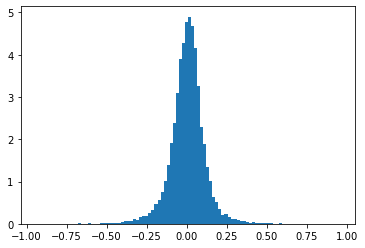

In [24]:
plt.hist(foldchange, bins=100, density=True);

Plotting a histogram of fold-change values, we see that most genes are **not** differentially expressed. Usually, fold-change values of at least 2 in absolute value are required to consider that a gene is differentially expressed. Also typically, a combination of fold-change and p-value requirements is considered. Today we will just ignore those practices and select the top 50 DE genes.

Since we care about both **over** and **under** expressed genes, we must take the absolute value before sorting. Also, we use the `.index[]` method to get the labels.

In [25]:
topDE = foldchange.abs().sort_values(ascending=False).index[:50]

Here we just resort the elements of `topDE` by foldchange value (without taking the absolute value)

In [26]:
topDE = foldchange.loc[topDE].sort_values().index

We now plot a heatmap of the expression of these genes

<AxesSubplot:ylabel='name'>

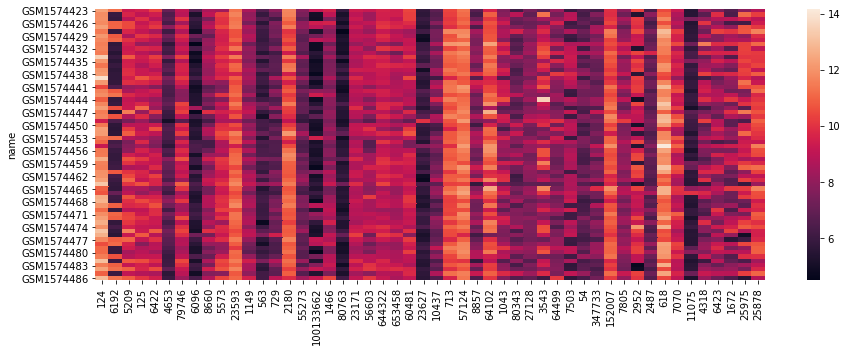

In [27]:
plt.figure(figsize=(15,5))
sns.heatmap(expr[topDE])

We do not see anything special here! What is going on? We are plotting raw log-expression values of all samples for the `topDE` genes. As each gene has a different scale, we don't see differences between samples. Also, we don't know if the samples are sorted or not. So let us introduces these changes:

+ Set the mean of all genes to 0
+ Sort the samples by BMI
+ use a divergent colormap

<AxesSubplot:>

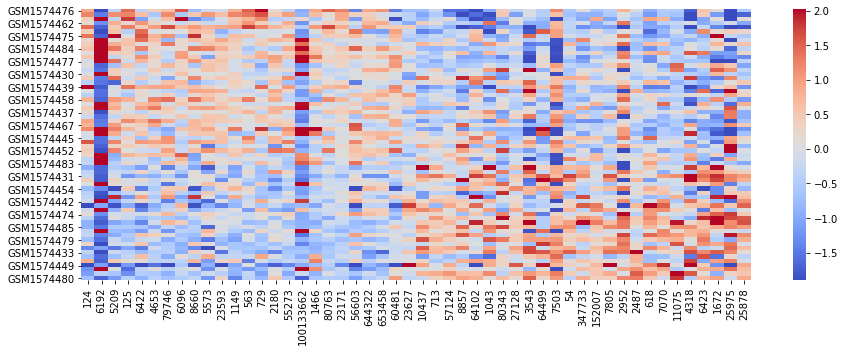

In [28]:
sorted_samples = meta.bmi.sort_values().index
plt.figure(figsize=(15,5))
sns.heatmap((expr-expr.mean()).loc[ sorted_samples, topDE ],
            robust=True,
            cmap="coolwarm")